<a href="https://colab.research.google.com/github/JHyunjun/TF2.0_Generative-Adversarial-Network/blob/main/JSA_cGAN_float16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

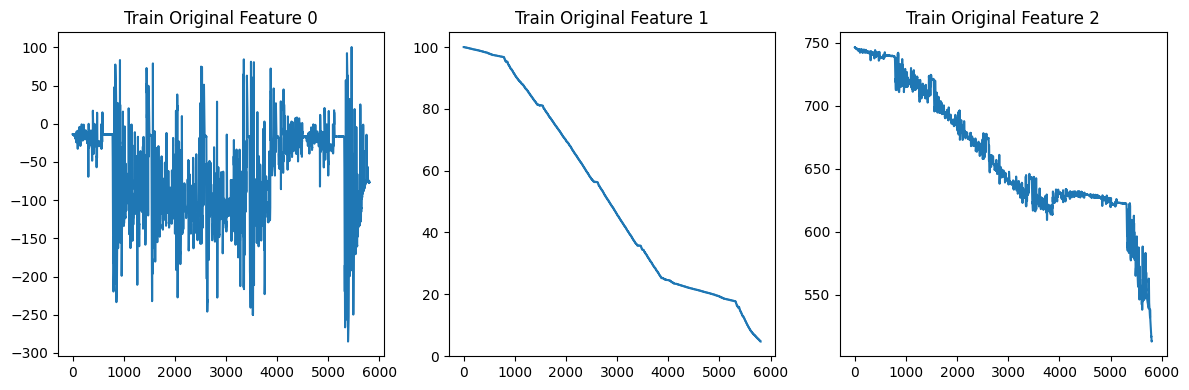

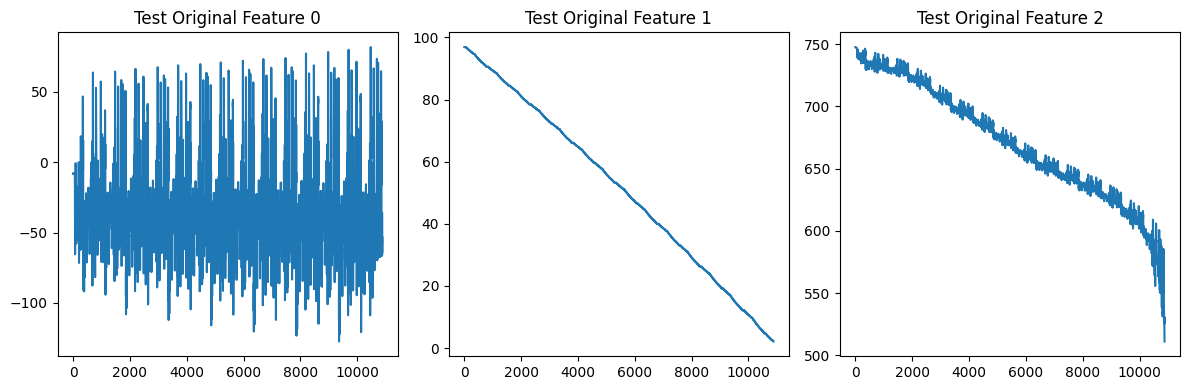

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Flatten, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay

tf.keras.mixed_precision.set_global_policy('mixed_float16')


import numpy as np
import matplotlib.pyplot as plt

def MinMaxScaler(data, data_min, data_max): # Scaling to 0~1
    return (data - data_min) / (data_max - data_min + 1e-7)

def min_max_scaler_neg1_to_1(data, data_min, data_max): # Scailing to -1~1 for tanh
    # data_min, data_max는 각각 각 피처의 최소, 최대값 (numpy array)
    return 2 * (data - data_min) / (data_max - data_min + 1e-7) - 1

def denormalize_feature(data, feature_index, data_min, data_max):
    # data: numpy array with shape (..., features)
    # 개별 피처(feature_index)에 대해 de-normalize 수행
    return data[..., feature_index] * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

train_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt", delimiter = ",")
test_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt", delimiter = ",")
train_data = train_data.iloc[:,[0,2,4]] # Current, SOC, Pack Voltage(192 Cells)
cols = ['Current', 'SOC', 'Voltage']
train_data.columns = cols
test_data = test_data.iloc[:,[0,2,4]]
test_data.columns = cols

plt.figure(figsize=(12, 4))
for i in range(train_data.shape[1]):
    plt.subplot(1, train_data.shape[1], i+1)
    plt.plot(train_data.iloc[:, i])
    plt.title(f"Train Original Feature {i}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(test_data.shape[1]):
    plt.subplot(1, test_data.shape[1], i+1)
    plt.plot(test_data.iloc[:, i])
    plt.title(f"Test Original Feature {i}")
plt.tight_layout()
plt.show()

Scaled Train data :
 [[0.70383817 1.         0.99450549]
 [0.70306017 1.         0.99492815]
 [0.70357884 1.         0.99408284]
 ...
 [0.54149378 0.02655771 0.01183432]
 [0.54175311 0.02655771 0.00887574]
 [0.5409751  0.02655771 0.0101437 ]]
Scaled Test data :
 [[0.71810166 0.96833503 1.        ]
 [0.71810166 0.96833503 1.        ]
 [0.71810166 0.96833503 1.        ]
 ...
 [0.57131743 0.         0.01690617]
 [0.57053942 0.         0.00803043]
 [0.57002075 0.         0.        ]]
Scaled Combined data:
 (16689, 3) [[0.70383817 1.         0.99450549]
 [0.70306017 1.         0.99492815]
 [0.70357884 1.         0.99408284]
 ...
 [0.57131743 0.         0.01690617]
 [0.57053942 0.         0.00803043]
 [0.57002075 0.         0.        ]]
Train data.shape :  (5807, 3)
Train sequences shape :  (579, 20, 3)
All data.shape :  (16689, 3)
All sequences shape :  (1667, 20, 3)


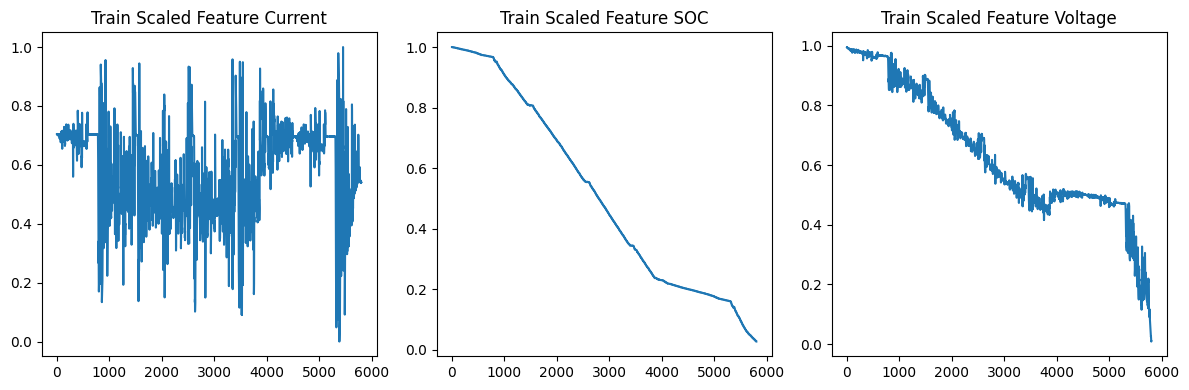

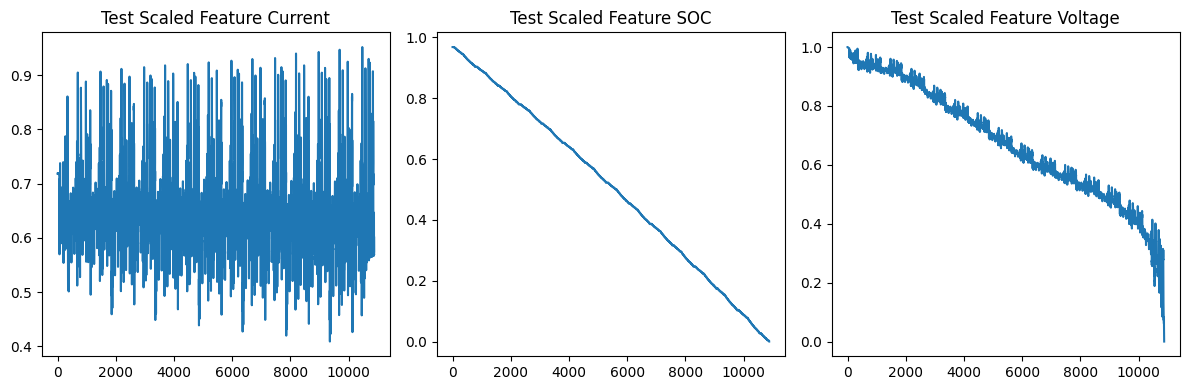

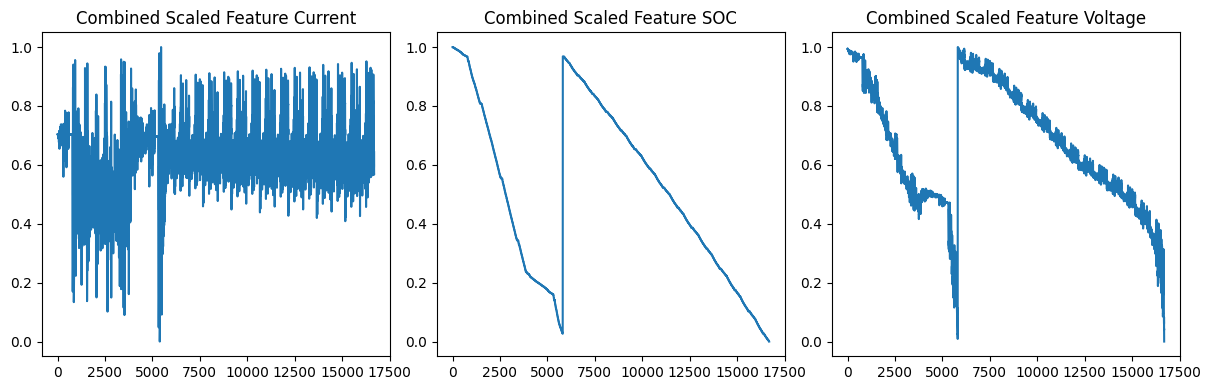

In [ ]:
# Data Normalization 0~1
combined_data = pd.concat([train_data, test_data], ignore_index=True)
data_min = combined_data.min().values
data_max = combined_data.max().values
train_scaled = MinMaxScaler(train_data.values, data_min, data_max)
test_scaled = MinMaxScaler(test_data.values, data_min, data_max)
print("Scaled Train data :\n", train_scaled)
print("Scaled Test data :\n", test_scaled)

all_scaled = MinMaxScaler(combined_data.values, data_min, data_max)

print("Scaled Combined data:\n", all_scaled.shape, all_scaled)


# Data Normalization -1 ~ 1
# combined_data = pd.concat([train_data, test_data], ignore_index=True)
# data_min = combined_data.min().values
# data_max = combined_data.max().values
# train_scaled = min_max_scaler_neg1_to_1(train_data.values, data_min, data_max)
# test_scaled = min_max_scaler_neg1_to_1(test_data.values, data_min, data_max)
window_size = 20

# Data Slicing
def create_sequences_non_overlapping(data, window_size= window_size, overlap=0.5):
    stride = int(window_size * (1 - overlap))  # 예: window_size=20, overlap=0.5 → stride=10
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

train_sequences = create_sequences_non_overlapping(train_scaled, window_size= window_size,overlap = 0.5)
all_sequences = create_sequences_non_overlapping(all_scaled, window_size = window_size,overlap = 0.5)

print("Train data.shape : ", train_scaled.shape)
print("Train sequences shape : ", train_sequences.shape)  # (num_samples, 10, 3)

print("All data.shape : ", all_scaled.shape)
print("All sequences shape : ", all_sequences.shape)  # (num_samples, 10, 3)

plt.figure(figsize=(12, 4))
for i in range(train_scaled.shape[1]):
    plt.subplot(1, train_scaled.shape[1], i+1)
    plt.plot(train_scaled[:, i])
    plt.title(f"Train Scaled Feature {cols[i]}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(test_scaled.shape[1]):
    plt.subplot(1, test_scaled.shape[1], i+1)
    plt.plot(test_scaled[:, i])
    plt.title(f"Test Scaled Feature {cols[i]}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(all_scaled.shape[1]):
    plt.subplot(1, all_scaled.shape[1], i+1)
    plt.plot(all_scaled[:, i])
    plt.title(f"Combined Scaled Feature {cols[i]}")
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, ConvLSTM2D, TimeDistributed, Conv2D, Flatten, Input, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Hyper Parameter
feature_dim = 3        # 전체 피처 수: [전류, SOC, 전압]
latent_dim = 30        # 잠재 공간 차원 (노이즈의 차원)
batch_size = 128
epochs = 300
n_critic = 3
lambda_gp = 15.0
learning_rate = 1e-4

# -----------------------------
# ConvLSTM 기반 Generator 모델 (예시)
# 입력: latent vector, 출력: (window_size, 3) 시퀀스
# -----------------------------
# --- 조건: SOC는 변화가 작으므로, 조건으로 사용 (단일 스칼라 per 시퀀스) ---
# 여기서는 각 시퀀스에서 SOC는 마지막 시점의 SOC 값으로 가정하고, 이를 시퀀스 전체로 복제합니다.
def get_condition(real_series):
    # real_series: (batch, window_size, feature_dim)
    # SOC는 feature index 1.
    soc = real_series[:, -1, 1]  # (batch,)
    soc = tf.expand_dims(soc, axis=1)  # (batch, 1)
    soc = tf.tile(soc, [1, window_size])  # (batch, window_size)
    soc = tf.expand_dims(soc, axis=-1)  # (batch, window_size, 1)
    return soc

# --- 조건부 Generator ---
def build_generator_cond(latent_dim, window_size):
    """
    Generator는 노이즈와 조건(SOC)을 받아서 동적 피처(전류, 전압)를 생성합니다.
    입력: (batch, window_size, latent_dim) 노이즈와 (batch, window_size, 1) condition
    출력: (batch, window_size, 2) 동적 피처 (전류, 전압)
    """
    noise_inp = Input(shape=(window_size, latent_dim))
    cond_inp = Input(shape=(window_size, 1))
    # Concatenate along feature axis → (batch, window_size, latent_dim+1)
    x = Concatenate(axis=-1)([noise_inp, cond_inp])

    # 각 시점에 대해 TimeDistributed Dense: (window_size, latent_dim+1) -> (window_size, 16)
    x = TimeDistributed(Dense(64))(x)
    x = TimeDistributed(LeakyReLU(alpha=0.2))(x)

    # Reshape for ConvLSTM2D: reshape to 5D: (batch, window_size, rows, cols, channels)
    # 여기서는 rows=1, cols=16, channels=1
    x = Reshape((window_size, 1, 64, 1))(x)

    # ConvLSTM2D 층: 시간적 및 공간적 패턴 학습
    x = ConvLSTM2D(filters=64, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=32, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=16, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # TimeDistributed Conv2D: 채널 수를 1로 축소, 활성화: tanh
    x = TimeDistributed(Conv2D(filters=1, kernel_size=(1,3), padding='same'))(x)
    x = TimeDistributed(LeakyReLU(alpha=0.2))(x)

    # Reshape: (batch, window_size, 1, 16, 1) → 먼저 flatten spatial dims → (batch, window_size, ?)
    # 여기서는 최종 동적 피처 수가 2 (전류, 전압)로 나오도록 Dense 층 적용
    x = TimeDistributed(Flatten())(x)
    dynamic_out = TimeDistributed(Dense(2, activation='sigmoid'))(x)

    model = Model([noise_inp, cond_inp], dynamic_out, name="Generator_Conditional")
    return model

# 최종 생성 시퀀스: Generator의 동적 출력 (전류, 전압)와 조건으로 주어진 SOC를 concat하여 (window_size, 3) 만듦.
def combine_output(dynamic, cond):
    cond = tf.cast(cond, dynamic.dtype)  # dynamic과 같은 타입으로 변환
    return tf.concat([dynamic, cond], axis=-1)  # 최종 ordering: [전류, 전압, SOC]

# --- Discriminator (Conditional 방식은 간단히 전체 시퀀스를 받음) ---
def build_discriminator(input_shape):
    model = Sequential(name="Critic")
    # 입력 shape: (window_size, 3)
    window_size = input_shape[0]
    num_features = input_shape[1]
    model.add(Reshape((window_size, 1, num_features, 1), input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, num_features), padding='same', return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(ConvLSTM2D(filters=16, kernel_size=(1, num_features), padding='same', return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(ConvLSTM2D(filters=8, kernel_size=(1, num_features), padding='same', return_sequences=False))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1))
    return model

# 모델 생성
generator_cond = build_generator_cond(latent_dim, window_size)
# Discriminator는 입력 full sequence: (window_size, 3)
discriminator = build_discriminator((window_size, 3))

# 옵티마이저 설정
generator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)

# tf.data.Dataset 구성: all_sequences의 shape은 (num_samples, window_size, feature_dim)
# 여기서 all_sequences는 이미 non-overlapping 방식으로 slicing된 데이터
dataset = tf.data.Dataset.from_tensor_slices(all_sequences.astype('float32')).shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Function Setting
# --- Gradient Penalty 계산 함수 (WGAN-GP) ---
@tf.function
def gradient_penalty(discriminator, real_samples, fake_samples):
    # fake_samples를 real_samples와 같은 타입으로 캐스팅
    fake_samples = tf.cast(fake_samples, real_samples.dtype)
    batch_size = tf.shape(real_samples)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0, dtype=real_samples.dtype)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = tf.reduce_mean((grad_norm - 1.0) ** 2)
    return gp

teacher_model = load_model("refined_1d_cnn.h5")
teacher_model.trainable = False

# --- Training Step ---
@tf.function
def train_step(real_series):
    # real_series: (batch, window_size, feature_dim)
    # 1. Discriminator 업데이트
    cond = get_condition(real_series)  # (batch, window_size, 1)
    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim])
    # Generator에 두 입력 전달
    latent_fake = generator_cond([noise, cond], training=True)  # shape: (batch, window_size, 2)
    fake_series = combine_output(latent_fake, cond)  # 최종 (batch, window_size, 3)

    with tf.GradientTape() as tape:
        d_real = discriminator(real_series, training=True)
        d_fake = discriminator(fake_series, training=True)
        d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        gp = gradient_penalty(discriminator, real_series, fake_series)
        d_loss_total = d_loss + tf.cast(lambda_gp, d_loss.dtype) * tf.cast(gp, d_loss.dtype)

    gradients = tape.gradient(d_loss_total, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # 2. Generator 업데이트
    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim])
    with tf.GradientTape() as tape:
        latent_fake = generator_cond([noise, cond], training=True)
        fake_series = combine_output(latent_fake, cond)  # (batch, window_size, 3); 순서: [전류, 전압, SOC]
        d_fake = discriminator(fake_series, training=True)
        g_adv_loss = -tf.reduce_mean(d_fake)

        # Teacher model을 이용한 supervised loss 계산
        # Teacher 모델은 [전류, SOC]를 입력으로 받고 전압을 예측함
        teacher_input = tf.concat([fake_series[..., 0:1], fake_series[..., 2:3]], axis=-1)  # shape: (batch, window_size, 2)
        teacher_prediction = teacher_model(teacher_input, training=False)  # 예측된 전압, shape: (batch, window_size, 1)
        # 실제 생성된 전압 (채널 인덱스 1)과의 MSE 계산
        teacher_loss = tf.reduce_mean(
        tf.square(
        teacher_prediction - tf.cast(fake_series[..., 1:2], teacher_prediction.dtype)
         )
)

        # 두 손실의 균형을 위해 supervised loss에 가중치(alpha)를 부여 (예: 0.01)
        alpha = 0.1
        g_loss_total = g_adv_loss + tf.cast(alpha * teacher_loss, g_adv_loss.dtype)

    gradients = tape.gradient(g_loss_total, generator_cond.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator_cond.trainable_variables))

    return d_loss, g_loss_total, gp

In [ ]:
# Training
for epoch in range(epochs):
    total_d, total_g, total_gp, count = 0.0, 0.0, 0.0, 0
    for real_batch in dataset:
        d_loss_val, g_loss_val, gp_val = train_step(real_batch)
        total_d += d_loss_val
        total_g += g_loss_val
        total_gp += gp_val
        count += 1
    if epoch % 50 == 0:
        print(f"Epoch {epoch} | D Loss: {total_d/count:.4f}, GP: {total_gp/count:.4f}, G Loss: {total_g/count:.4f}")

TypeError: in user code:

    File "C:\Users\user\AppData\Local\Temp\ipykernel_56408\2987371794.py", line 63, in train_step  *
        g_loss_total = g_adv_loss + alpha * teacher_loss

    TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type float16 of argument 'x'.


In [ ]:
print("data_min : ", data_min)
print("data_max : ", data_max)

data_min :  [-285.1    2.1  511. ]
data_max :  [100.5 100.  747.6]


Generated sequence shape: (1, 20, 3)


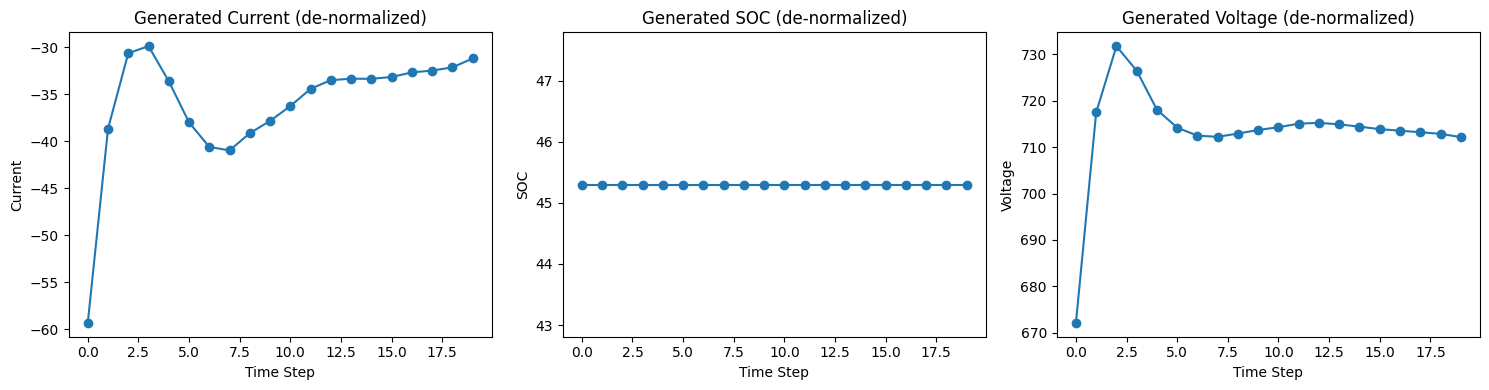

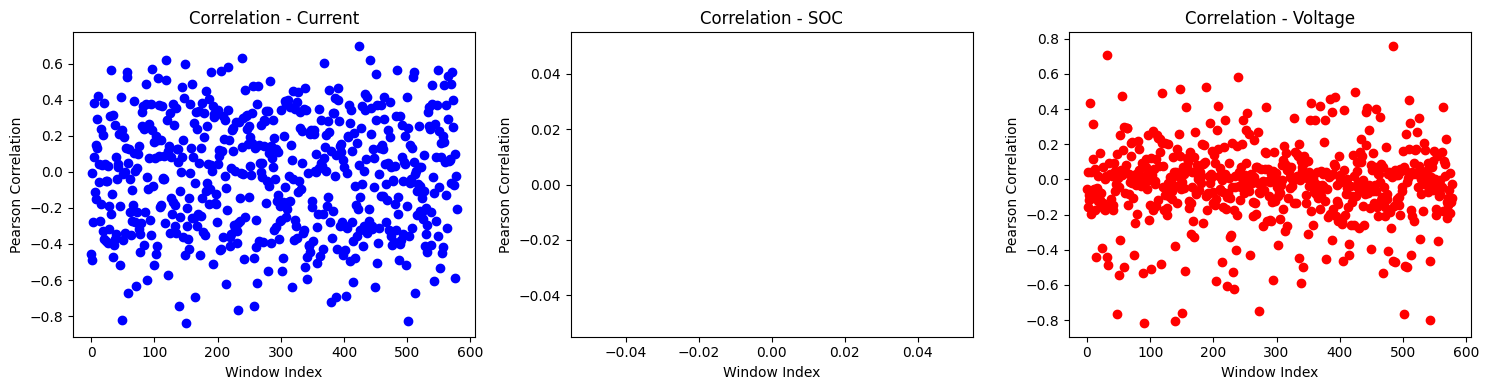

In [ ]:
def combine_output(dynamic, cond):
    # dynamic: (batch, window_size, 2) → [전류, 전압]
    # cond: (batch, window_size, 1) → SOC
    # 우선 cond를 float32로 캐스팅
    cond = tf.cast(cond, tf.float32)
    # 최종 출력: (batch, window_size, 3) → [전류, SOC, 전압]
    current = dynamic[..., :1]      # 첫번째 채널: 전류
    voltage = dynamic[..., 1:]        # 두번째 채널: 전압
    return tf.concat([current, cond, voltage], axis=-1)

# 생성된 시계열 확인 (조건부 Generator는 두 입력을 받음)
# 여기서는 training=False로 샘플 생성
# 1. 임의의 노이즈 샘플 (shape: (1, window_size, latent_dim))
noise_sample = tf.random.normal([1, window_size, latent_dim])
# 2. 조건 샘플: all_sequences의 특정 샘플에서 SOC 값을 추출 (shape: (1, window_size, 1))
cond_sample = get_condition(all_sequences[300:301])
# 3. 조건부 Generator에 두 입력을 별도로 전달 (리스트로)
latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)  # (1, window_size, 2)
# 4. 동적 피처(전류, 전압)와 조건(SOC)을 결합하여 최종 생성 시퀀스 생성 (1, window_size, 3)
generated_sequence = combine_output(latent_dynamic, cond_sample)
print("Generated sequence shape:", generated_sequence.shape)  # 예: (1, 10, 3)

# 선택: 첫 번째 시퀀스 추출 (shape: (window_size, 3))
gen_seq = generated_sequence[0].numpy()

# Denormalization 함수는 이미 정의되어 있다고 가정 (예: denormalize_feature)
# 예시: denormalize_feature(data, feature_index, data_min, data_max)
gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)  # 전류
gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)  # SOC
gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)  # 전압

# 각 피처별 생성 데이터 시각화 (원래 스케일)
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(gen_current_denorm, marker='o')
plt.title('Generated Current (de-normalized)')
plt.xlabel('Time Step')
plt.ylabel('Current')

plt.subplot(1,3,2)
plt.plot(gen_soc_denorm, marker='o')
plt.title('Generated SOC (de-normalized)')
plt.xlabel('Time Step')
plt.ylabel('SOC')

plt.subplot(1,3,3)
plt.plot(gen_voltage_denorm, marker='o')
plt.title('Generated Voltage (de-normalized)')
plt.xlabel('Time Step')
plt.ylabel('Voltage')
plt.tight_layout()
plt.show()

# --- 각 슬라이딩 윈도우별 상관계수 계산 ---
# train_sequences: (num_windows, window_size, feature_dim)
n_windows = train_sequences.shape[0]
corr_current = []
corr_soc = []
corr_voltage = []

for i in range(n_windows):
    window = train_sequences[i]  # shape: (window_size, 3)
    # 각 윈도우의 피처별로 de-normalize
    window_current = denormalize_feature(window, 0, data_min, data_max)
    window_soc     = denormalize_feature(window, 1, data_min, data_max)
    window_voltage = denormalize_feature(window, 2, data_min, data_max)

    # Pearson 상관계수 계산 (np.corrcoef returns 2x2 matrix, [0,1]가 상관계수)
    corr_current.append(np.corrcoef(window_current, gen_current_denorm)[0, 1])
    corr_soc.append(np.corrcoef(window_soc, gen_soc_denorm)[0, 1])
    corr_voltage.append(np.corrcoef(window_voltage, gen_voltage_denorm)[0, 1])

# 상관계수 결과를 점으로 플롯 (피처별)
x = np.arange(n_windows)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(x, corr_current, marker='o', color='blue')
plt.title('Correlation - Current')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,2)
plt.scatter(x, corr_soc, marker='o', color='green')
plt.title('Correlation - SOC')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,3)
plt.scatter(x, corr_voltage, marker='o', color='red')
plt.title('Correlation - Voltage')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.tight_layout()
plt.show()


Generated sequence shape: (1, 20, 3)


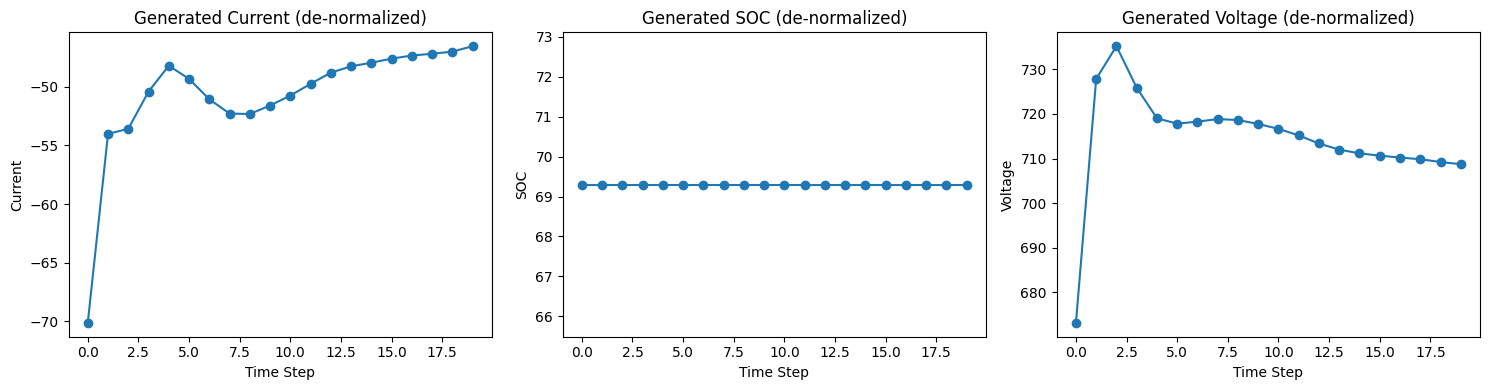

MSE between 1D-CNN prediction and GAN generated voltage: 385.91626
Pearson Correlation: 0.15880077180930552


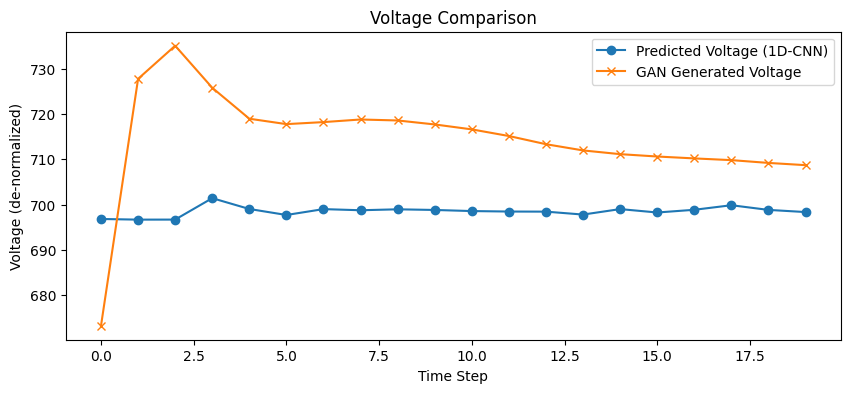

In [ ]:
# 가정: all_sequences는 원본 데이터에서 non-overlapping 슬라이싱된 배열
# shape: (num_samples, window_size, 3), 채널 순서: [전류, SOC, 전압]
# data_min, data_max: 각각 [전류_min, SOC_min, Voltage_min] / [전류_max, SOC_max, Voltage_max]
# 예시)
# data_min = np.array([-285.1, 2.1, 511.0])
# data_max = np.array([100.5, 100.0, 747.6])
# all_sequences 는 이미 메모리에 존재한다고 가정

# ----------------------------------------------------------------------
# 1. 1D-CNN 모델: 전류, SOC -> 전압 예측
# 입력: (window_size, 2), 출력: (window_size, 1)

# initial_lr = 1e-4
# decay_rate = 0.9  # 매 decay_steps마다 lr을 0.99배
# decay_steps = 500 # 스텝 수(배치 단위). 필요에 맞게 조절

# lr_schedule = ExponentialDecay(
#     initial_learning_rate=initial_lr,
#     decay_steps=decay_steps,
#     decay_rate=decay_rate,
#     staircase=False  # True면 decay_steps마다 단계적으로 떨어짐
# )

# optimizer = Adam(learning_rate=lr_schedule)

# def build_refined_cnn(input_shape):
#     inputs = Input(shape=input_shape)
#     # Convolution Block 1
#     x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
#     x = BatchNormalization()(x)
#     # Convolution Block 2
#     x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     # Convolution Block 3
#     x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     # Convolution Block 4
#     x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     # Convolution Block 5
#     x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     # TimeDistributed Dense layers
#     x = TimeDistributed(Dense(64, activation='relu'))(x)
#     x = TimeDistributed(Dense(32, activation='relu'))(x)
#     outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)  # 각 시점의 전압 예측
#     model = Model(inputs, outputs, name="Refined_1D_CNN")
#     return model

# # window_size 설정 (예: 10)
# window_size = window_size
# input_shape_cnn = (window_size, 2)  # 전류와 SOC

# # 원본 all_sequences에서 학습 데이터 추출
# # all_sequences shape: (num_samples, window_size, 3)
# # X: 전류와 SOC (채널 0과 1), Y: 전압 (채널 2)
# train_X = all_sequences[..., :2]   # shape: (num_samples, window_size, 2)
# train_Y = all_sequences[..., 2:]   # shape: (num_samples, window_size, 1)

# # 모델 생성 및 학습
# voltage_model = build_refined_cnn(input_shape_cnn)
# voltage_model.summary()
# voltage_model.compile(optimizer=optimizer, loss='mse')

# # tf.data.Dataset 구성
# train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).shuffle(buffer_size=1024).batch(256).prefetch(tf.data.AUTOTUNE)

# # 500 epoch 학습
# history = voltage_model.fit(train_dataset, epochs=10000)

# # 모델 저장 (freeze된 모델로 사용)
# voltage_model.save("refined_1d_cnn.h5")
# voltage_model.trainable = False

voltage_model = load_model('refined_1d_cnn.h5')

# ----------------------------------------------------------------------
# 2. GAN 생성 데이터 평가용 함수들 (조건부 GAN에서 생성된 시퀀스 평가)
# GAN 생성 데이터는 (1, window_size, 3) 형태로, 채널 순서가 [전류, SOC, 전압]라고 가정합니다.
# get_condition 및 combine_output은 아래와 같이 정의합니다.
def get_condition(real_series):
    # real_series: (batch, window_size, feature_dim)
    # SOC는 feature index 1
    soc = real_series[:, -1, 1]  # (batch,)
    soc = tf.expand_dims(soc, axis=1)  # (batch, 1)
    soc = tf.tile(soc, [1, window_size])  # (batch, window_size)
    soc = tf.expand_dims(soc, axis=-1)  # (batch, window_size, 1)
    return soc

def combine_output(dynamic, cond):
    # dynamic: (batch, window_size, 2) → [전류, 전압]
    # cond: (batch, window_size, 1) → SOC
    # 최종 출력: (batch, window_size, 3) → [전류, SOC, 전압]
    current = dynamic[..., :1]      # 첫 번째 채널: 전류
    voltage = dynamic[..., 1:]        # 두 번째 채널: 전압
    cond = tf.cast(cond, tf.float32)
    return tf.concat([current, cond, voltage], axis=-1)

# ----------------------------------------------------------------------
# 3. 사전에 학습된 조건부 Generator (generator_cond)는 이미 학습되었거나 GAN 학습 후 생성된 모델이라고 가정
# 여기서는 예시로 불러온다고 가정하고, 실제로는 기존의 generator_cond 모델을 사용합니다.
# 예: generator_cond = tf.keras.models.load_model("generator_cond.h5")
# (아래 코드는 generator_cond 모델이 조건부로 노이즈와 조건을 받아 (batch, window_size, 2)를 출력한다고 가정)

# ----------------------------------------------------------------------
# 4. GAN 생성 데이터 평가
# GAN 생성 데이터에서 조건부 Generator의 두 입력은:
# - 노이즈: shape (1, window_size, latent_dim)
# - 조건: real data에서 추출한 SOC, shape (1, window_size, 1)
# Generator는 동적 피처 (전류, 전압)를 생성하고, combine_output을 통해 최종 시퀀스 [전류, SOC, 전압]를 구성합니다.

# 예시: 임의의 노이즈와 조건을 사용하여 생성
noise_sample = tf.random.normal([1, window_size, latent_dim])
# 여기서 all_sequences[100:101]를 사용해 조건을 추출
cond_sample = get_condition(all_sequences[200:201])  # (1, window_size, 1)
latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)  # (1, window_size, 2)
generated_sequence = combine_output(latent_dynamic, cond_sample)  # (1, window_size, 3)
print("Generated sequence shape:", generated_sequence.shape)  # (1, window_size, 3)

# 첫 번째 시퀀스 추출
gen_seq = generated_sequence[0].numpy()

# denormalize_feature 함수 (피처별 복원)
def denormalize_feature(data, feature_index, data_min, data_max):
    return data[..., feature_index] * (data_max[feature_index] - data_min[feature_index]) + data_min[feature_index]

# data_min, data_max는 [전류, SOC, 전압] 순서로 정해졌다고 가정
gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(gen_current_denorm, marker='o')
plt.title('Generated Current (de-normalized)')
plt.xlabel('Time Step')
plt.ylabel('Current')

plt.subplot(1,3,2)
plt.plot(gen_soc_denorm, marker='o')
plt.title('Generated SOC (de-normalized)')
plt.xlabel('Time Step')
plt.ylabel('SOC')

plt.subplot(1,3,3)
plt.plot(gen_voltage_denorm, marker='o')
plt.title('Generated Voltage (de-normalized)')
plt.xlabel('Time Step')
plt.ylabel('Voltage')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 5. 1D-CNN 모델을 이용한 전압 예측 평가
# GAN 생성 시퀀스의 전류와 SOC (채널 0과 1)를 1D-CNN 모델 입력으로 넣습니다.
gan_current_soc = generated_sequence[..., :2]  # (1, window_size, 2)
predicted_voltage = voltage_model(gan_current_soc)  # (1, window_size, 1)
predicted_voltage = tf.squeeze(predicted_voltage, axis=-1).numpy()[0]  # (window_size,)

# GAN이 생성한 전압은 생성 시퀀스의 채널 2.
gan_voltage = generated_sequence[0, :, 2].numpy()

# Denormalize: 전압은 feature index 2에 해당
def denorm_vector(vec, feature_index, data_min, data_max):
    return vec * (data_max[feature_index] - data_min[feature_index]) + data_min[feature_index]

predicted_voltage_denorm = denorm_vector(predicted_voltage, 2, data_min, data_max)
gan_voltage_denorm = denorm_vector(gan_voltage, 2, data_min, data_max)

# 평가: MSE 및 Pearson 상관계수
mse_value = np.mean((predicted_voltage_denorm - gan_voltage_denorm) ** 2)
corr_value = np.corrcoef(predicted_voltage_denorm, gan_voltage_denorm)[0, 1]
print("MSE between 1D-CNN prediction and GAN generated voltage:", mse_value)
print("Pearson Correlation:", corr_value)

plt.figure(figsize=(10,4))
plt.plot(predicted_voltage_denorm, label="Predicted Voltage (1D-CNN)", marker='o')
plt.plot(gan_voltage_denorm, label="GAN Generated Voltage", marker='x')
plt.title("Voltage Comparison")
plt.xlabel("Time Step")
plt.ylabel("Voltage (de-normalized)")
plt.legend()
plt.show()


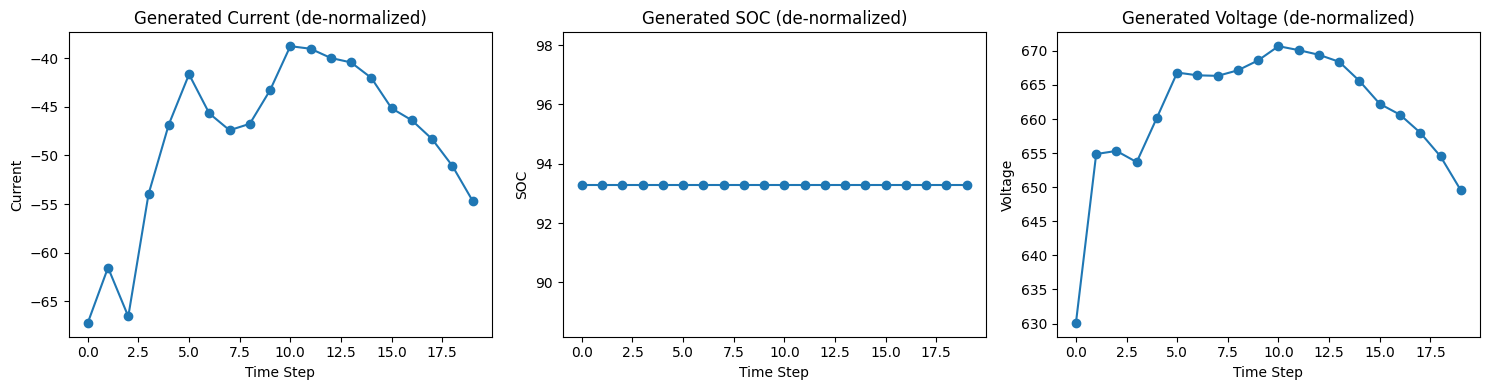

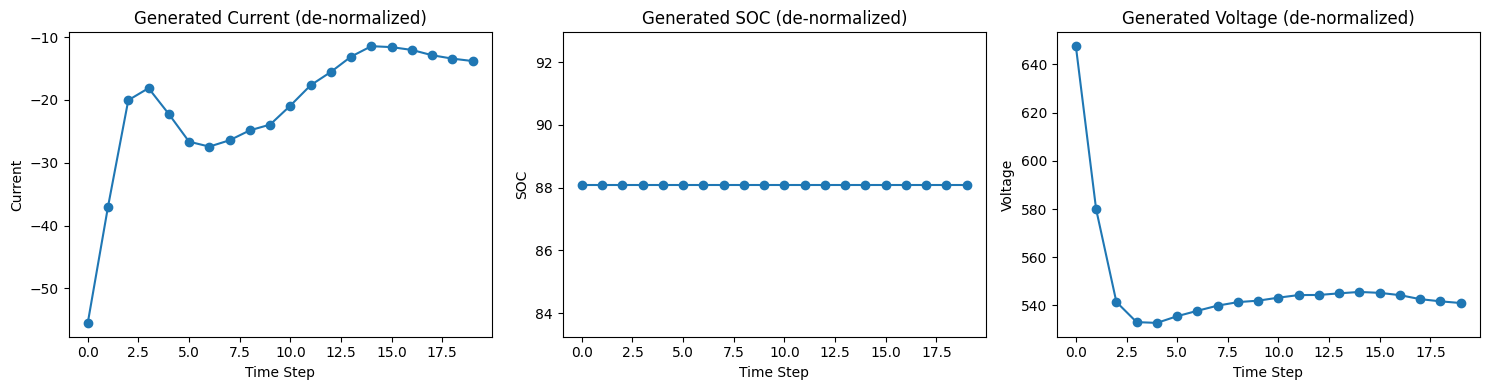

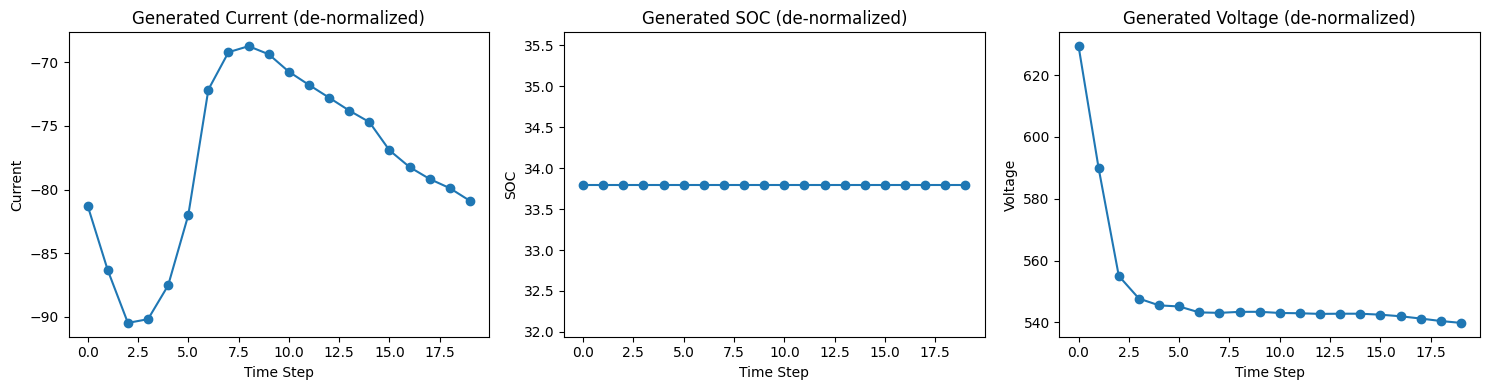

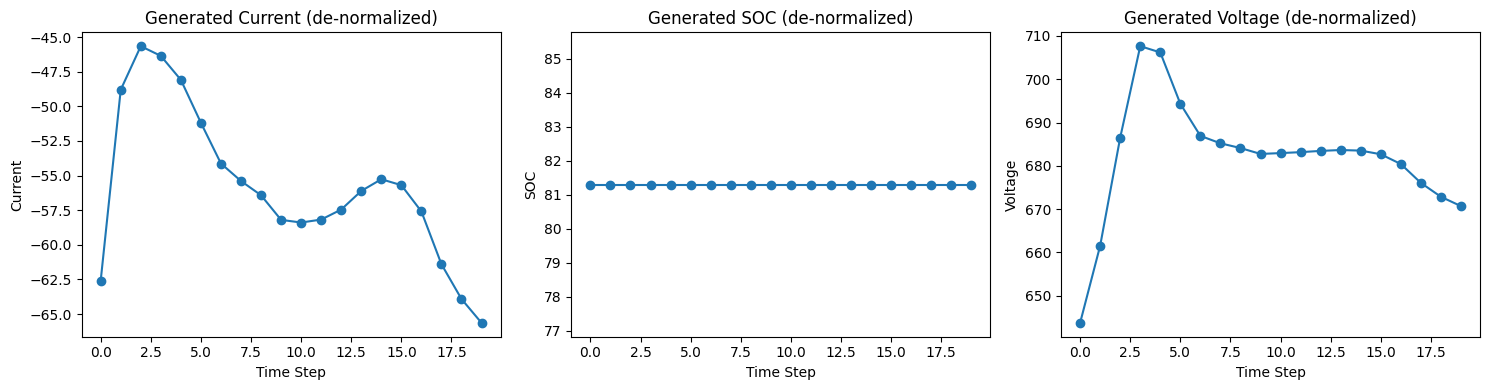

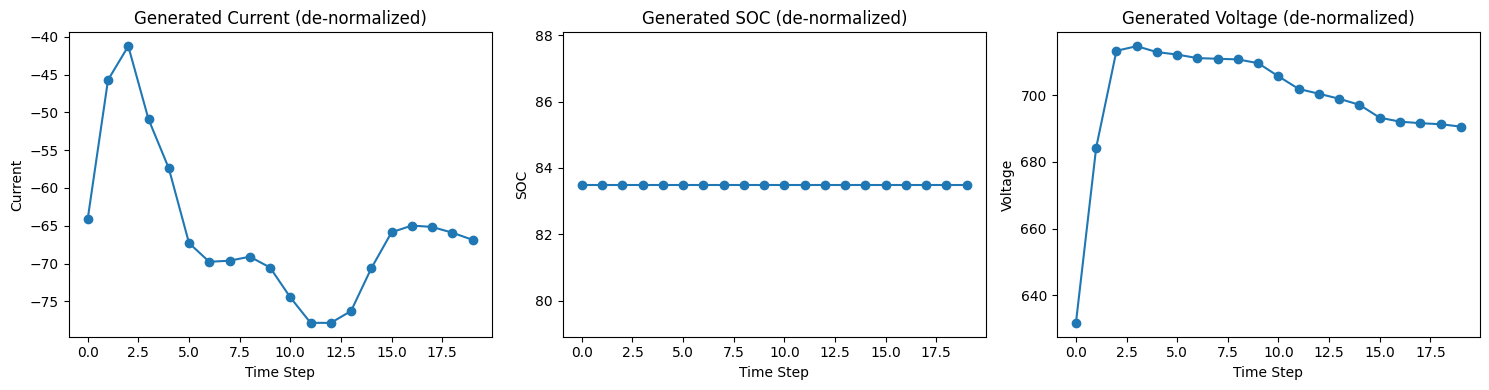

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_plots = 5
# GAN 생성 시 condition은 실제 데이터(all_sequences)에서 추출하므로,
# 랜덤하게 몇 개의 윈도우 인덱스를 선택합니다.
indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

for idx in indices:
    # 선택한 인덱스에 대해, 1개의 시퀀스 (shape: (1, window_size, 3))를 가져와서 condition을 추출합니다.
    cond_sample = get_condition(all_sequences[idx:idx+1])  # (1, window_size, 1)
    noise_sample = tf.random.normal([1, window_size, latent_dim])

    # Generator를 이용해 새로운 동적 피처 [전류, 전압]를 생성한 후,
    # condition(SOC)과 결합하여 최종 GAN 생성 시퀀스 [전류, SOC, 전압]를 구성합니다.
    latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)  # (1, window_size, 2)
    generated_sequence = combine_output(latent_dynamic, cond_sample)  # (1, window_size, 3)

    # 생성된 시퀀스를 numpy 배열로 변환
    gen_seq = generated_sequence[0].numpy()

    # 각 피처를 de-normalize (원래 스케일로 복원)
    gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
    gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
    gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)

    # 각 영역별로 GAN이 생성한 전류, SOC, 전압을 시각화
    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.plot(gen_current_denorm, marker='o')
    plt.title('Generated Current (de-normalized)')
    plt.xlabel('Time Step')
    plt.ylabel('Current')

    plt.subplot(1,3,2)
    plt.plot(gen_soc_denorm, marker='o')
    plt.title('Generated SOC (de-normalized)')
    plt.xlabel('Time Step')
    plt.ylabel('SOC')

    plt.subplot(1,3,3)
    plt.plot(gen_voltage_denorm, marker='o')
    plt.title('Generated Voltage (de-normalized)')
    plt.xlabel('Time Step')
    plt.ylabel('Voltage')

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 111ms/step
[Window index: 827]
  MSE: 17.0332
  Pearson Corr: 0.5544


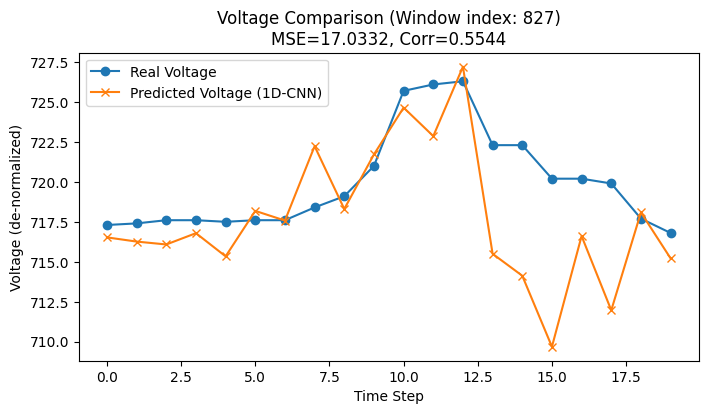

1/1 [==============================] - 0s 16ms/step
[Window index: 682]
  MSE: 0.6407
  Pearson Corr: 0.9381


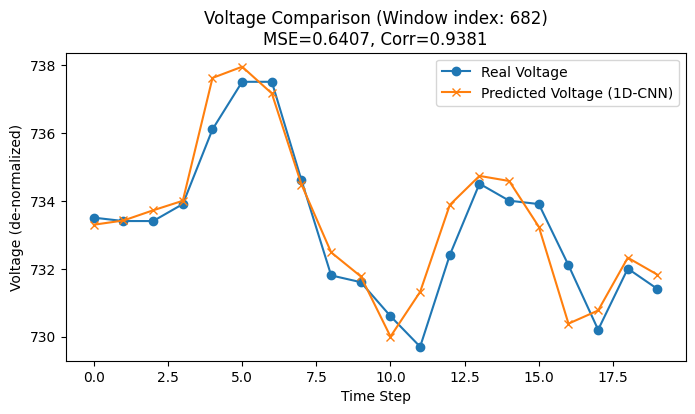

1/1 [==============================] - 0s 16ms/step
[Window index: 799]
  MSE: 31.3308
  Pearson Corr: 0.7637


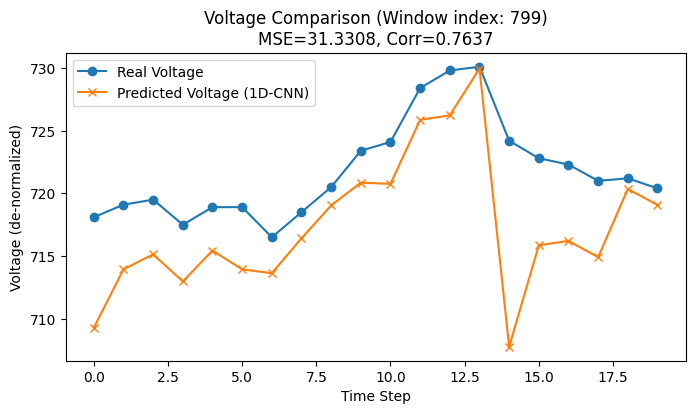

1/1 [==============================] - 0s 15ms/step
[Window index: 365]
  MSE: 12.1628
  Pearson Corr: 0.3103


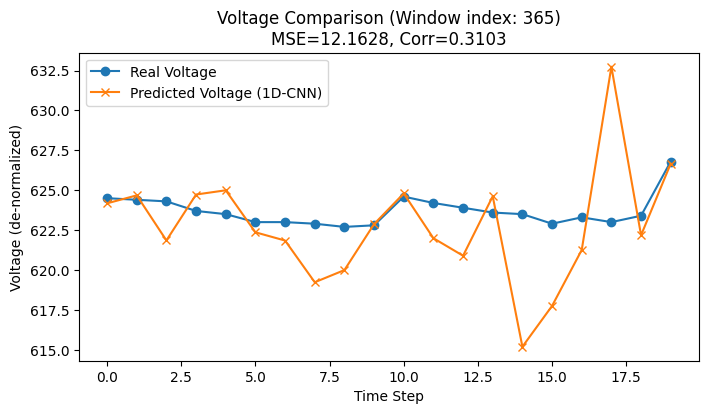

1/1 [==============================] - 0s 19ms/step
[Window index: 1312]
  MSE: 0.5618
  Pearson Corr: 0.7160


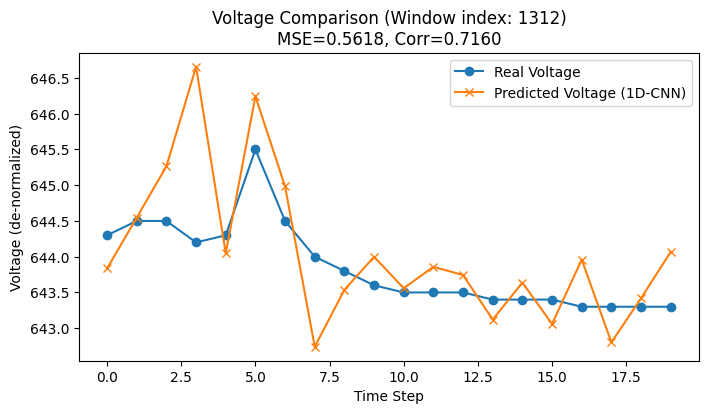

In [ ]:
## Teacher Model 검증증

num_plots = 5
indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

for idx in indices:
    # (1) 실제 데이터에서 X(전류+SOC)와 Y(전압) 추출
    real_current_soc = all_sequences[idx, :, :2]  # shape: (window_size, 2)
    real_voltage = all_sequences[idx, :, 2]       # shape: (window_size,)

    # (2) 모델 예측
    # 1D-CNN 모델은 (batch, window_size, 2) 형태의 입력을 받으므로 차원 추가
    real_current_soc_input = np.expand_dims(real_current_soc, axis=0)  # (1, window_size, 2)
    predicted_voltage = voltage_model.predict(real_current_soc_input)  # (1, window_size, 1)
    predicted_voltage = predicted_voltage[0, :, 0]  # (window_size,)

    # (3) De-normalize (전압 = feature_index=2)
    real_voltage_denorm = denorm_vector(real_voltage, 2, data_min, data_max)
    predicted_voltage_denorm = denorm_vector(predicted_voltage, 2, data_min, data_max)

    # (4) 오차 측정
    mse_value = np.mean((real_voltage_denorm - predicted_voltage_denorm) ** 2)
    corr_value = np.corrcoef(real_voltage_denorm, predicted_voltage_denorm)[0, 1]

    # (5) 결과 출력 및 시각화
    print(f"[Window index: {idx}]")
    print(f"  MSE: {mse_value:.4f}")
    print(f"  Pearson Corr: {corr_value:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(real_voltage_denorm, label="Real Voltage", marker='o')
    plt.plot(predicted_voltage_denorm, label="Predicted Voltage (1D-CNN)", marker='x')
    plt.title(f"Voltage Comparison (Window index: {idx})\nMSE={mse_value:.4f}, Corr={corr_value:.4f}")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (de-normalized)")
    plt.legend()
    plt.show()